In [91]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from matplotlib import animation
from IPython.display import HTML, Image
%matplotlib notebook
plt.rcParams.update({'font.size': 16})

In [68]:
def lasso(X, y, beta, lbd=.1):
    n, p = X.shape
    beta = beta.flatten()
    pred = X @ beta
    reg = lbd * np.sum(np.abs(beta))
    p = 1./(2*n) * np.linalg.norm(y.flatten() - pred.flatten(), 2)**2 + reg
    return p

In [87]:
def PGD_lasso(X, y, lbd=.1, epochs=1000):
    n, p = X.shape
    x_beta, y_beta = [0.], [0.]
    L = np.linalg.norm(X, ord=2) ** 2 * 2
    step_size = 1 / L
    mu = lbd / L
    w = np.zeros(p)
    cost = [lasso(X, y, w, lbd)]
    for i in range(epochs):
        w -= step_size * X.T @ (X @ w - y)
        w -= np.clip(w, -mu, mu)
        x_beta.append(w[0])
        y_beta.append(w[1])
        cost.append(lasso(X, y, w, lbd))
    return x_beta, y_beta, cost


def cd_lasso(X, y, lbd=.1, epochs=1000):
    L = (X ** 2).sum(axis=0) * 2
    p = X.shape[1]
    w = np.zeros(p)
    x_beta, y_beta = [0.], [0.] #Used for three d plot
    cost = [lasso(X, y, w, lbd)]
    R = np.copy(y)
    for _ in range(epochs):
        for j in range(p):
            if L[j] == 0.:
                continue
            old = w[j]
            w[j] = st(w[j] + X[:, j] @ R / L[j], lbd / L[j])
            diff = old - w[j]
            if diff != 0:
                R += diff * X[:, j]
            x_beta.append(w[0])
            y_beta.append(w[1])
            cost.append(lasso(X, y, w, lbd))
    return x_beta, y_beta, cost

def st(x, mu):
    if x > mu:
        return x - mu
    if x < - mu:
        return x + mu
    return 0.


In [88]:
np.random.seed(11234)
X = 10+15*np.random.randn(5000, 2)
y = X @ np.array([10, 7])

x_cd, y_cd, cost_cd = cd_lasso(X, y)
x_pgd, y_pgd, cost_pgd = PGD_lasso(X, y)

<IPython.core.display.Javascript object>


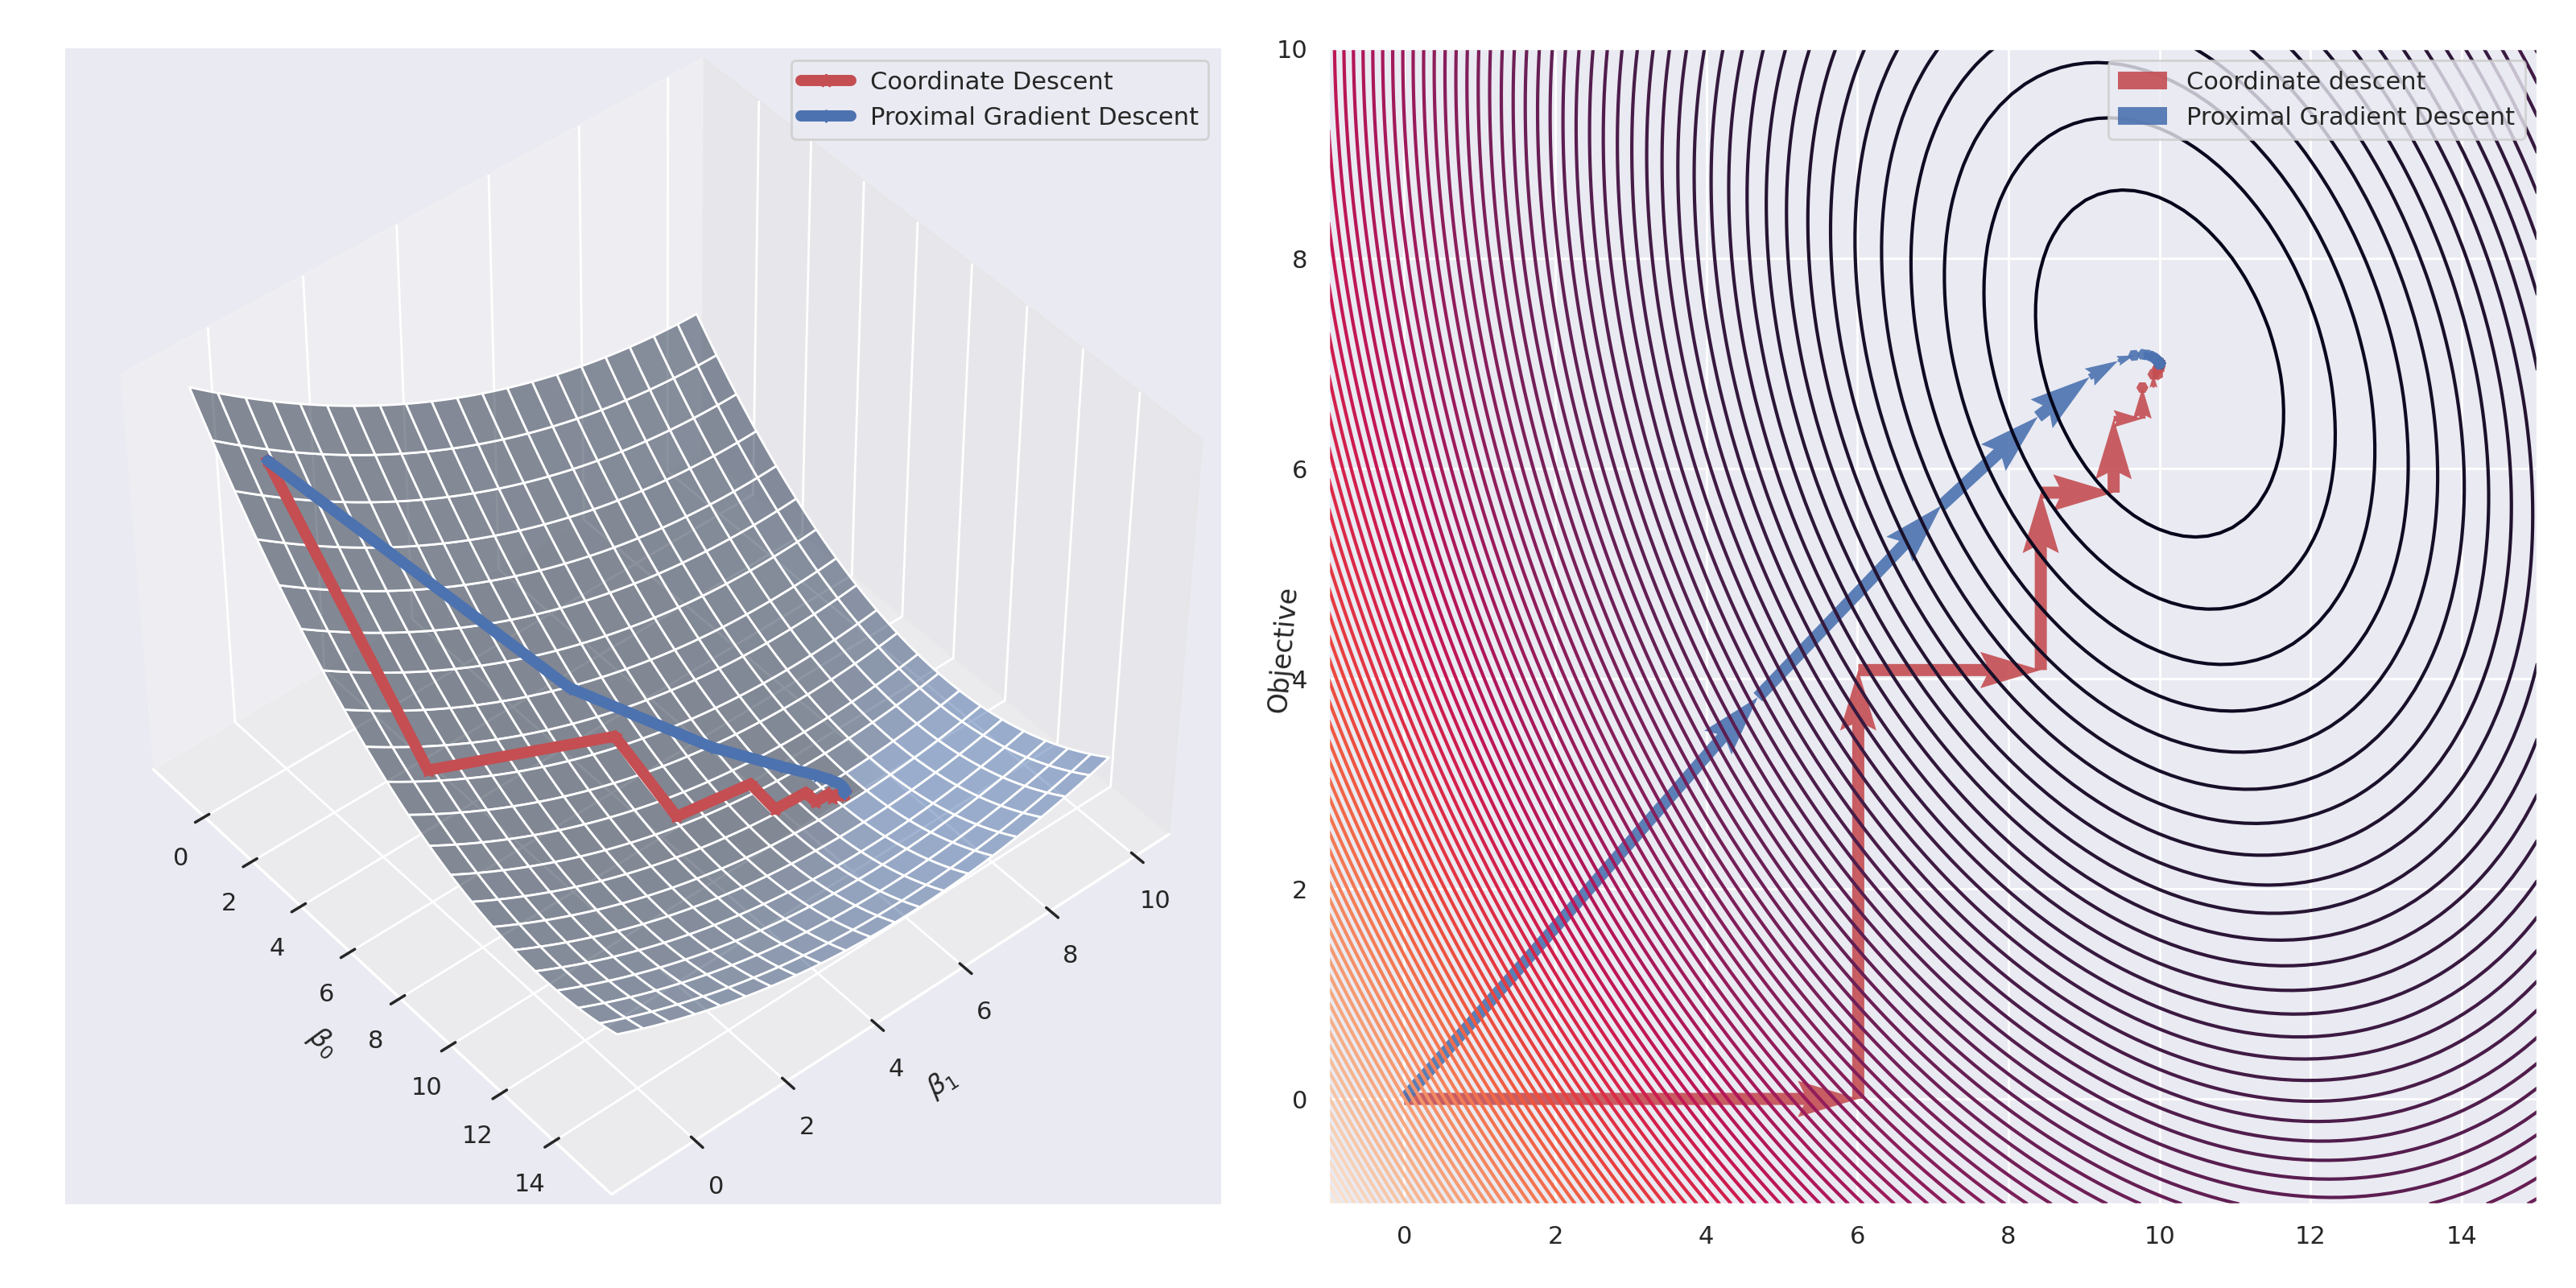

In [89]:
#Setup of meshgrid of theta values
T1, T2 = np.meshgrid(np.linspace(-1,15,100),np.linspace(-1,10,100))

#Computing the cost function for each theta combination
zlasso = np.array([lasso(X, y.reshape(-1,1), np.array([t1,t2]).reshape(-1,1), .1) 
                     for t1, t2 in zip(np.ravel(T1), np.ravel(T2)) ] )
#Reshaping the cost values    
Z = zlasso.reshape(T1.shape)


#Angles needed for quiver plot
anglesx = np.array(x_cd)[1:] - np.array(x_cd)[:-1]
anglesy = np.array(y_cd)[1:] - np.array(y_cd)[:-1]

anglesx2 = np.array(x_pgd)[1:] - np.array(x_pgd)[:-1]
anglesy2 = np.array(y_pgd)[1:] - np.array(y_pgd)[:-1]


fig = plt.figure(figsize = (16,8))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(T1, T2, Z, rstride = 5, cstride = 5, alpha=0.5)
ax.plot(x_cd,y_cd, cost_cd, marker = '*', color = 'r', alpha = 1, linewidth=5, label = 'Coordinate Descent')
ax.plot(x_pgd,y_pgd, cost_pgd, marker = '+', color = 'b', alpha = 1, linewidth=5, label = 'Proximal Gradient Descent')
ax.set_xlabel(r'$\beta_0$')
ax.set_ylabel(r'$\beta_1$')
ax.set_zlabel('Objective')
ax.w_zaxis.line.set_lw(0.)
ax.set_zticks([])
fig.tight_layout()
ax.legend()
ax.view_init(45, -40)

#Contour plot
ax = fig.add_subplot(1, 2, 2)
ax.contour(T1, T2, Z, 100)
ax.quiver(x_cd[:-1], y_cd[:-1], anglesx, anglesy, scale_units = 'xy', angles = 'xy', scale = 1,width=.01, color = 'r', alpha = .9, label = 'Coordinate descent')
ax.quiver(x_pgd[:-1], y_pgd[:-1], anglesx2, anglesy2, scale_units = 'xy', angles = 'xy', scale = 1, width=.01, color = 'b', alpha = .9, label = 'Proximal Gradient Descent')

fig.tight_layout()
ax.legend()
plt.savefig("coordinate_descente_intuition.pdf")
plt.show()

In [99]:
!pwd

/home/tlefort/Documents/phd/articles_and_others


<IPython.core.display.Javascript object>


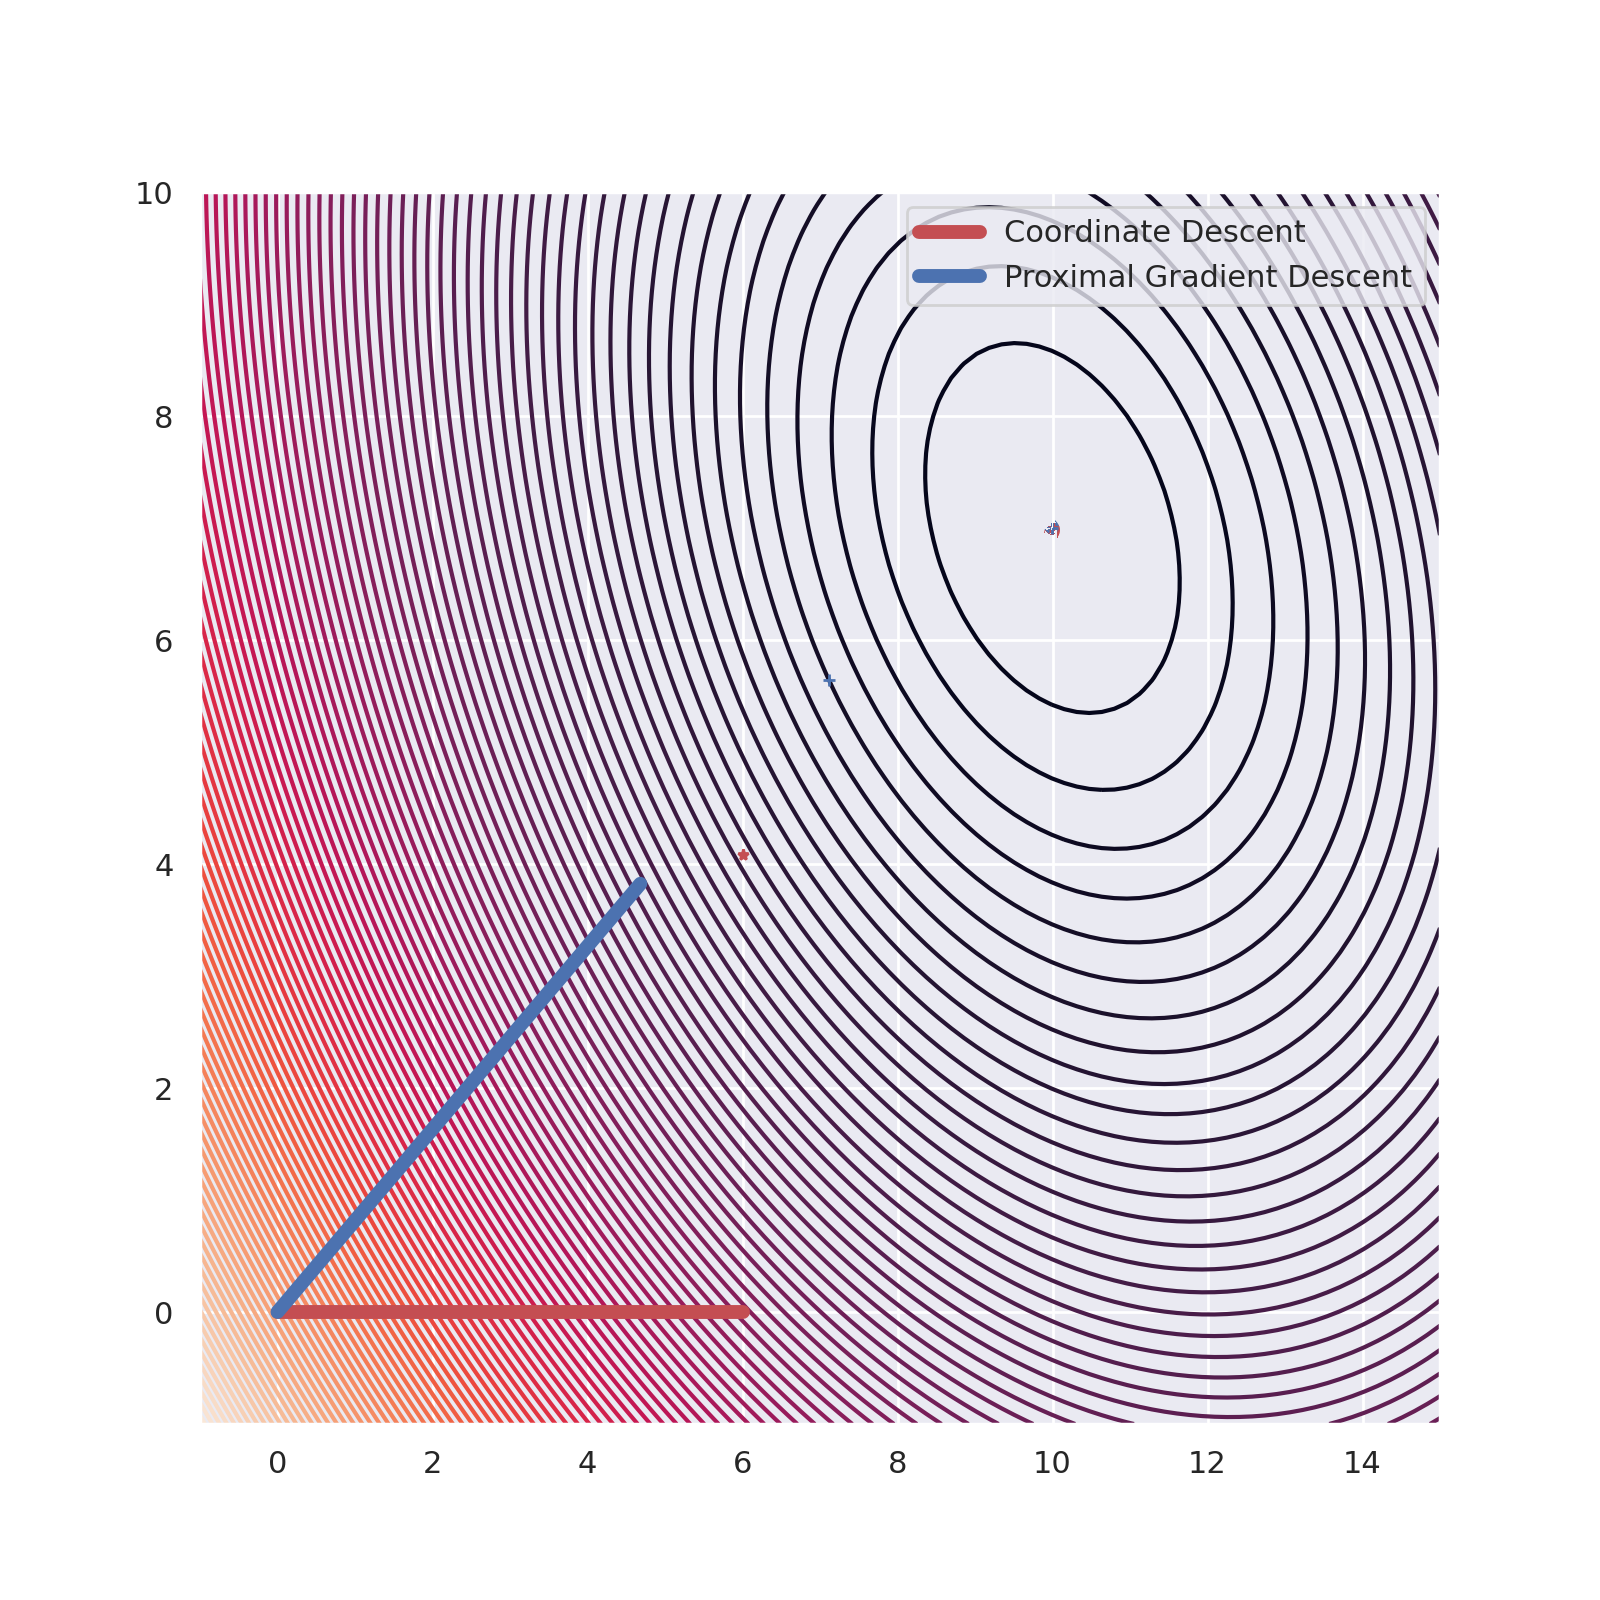

In [116]:
fig1, ax1 = plt.subplots(figsize = (8,8))
ax1.contour(T1, T2, Z, 100)
linecd, = ax1.plot([], [], 'r', label = 'Coordinate Descent', lw = 5)
linepgd, = ax1.plot([], [], 'b', label = 'Proximal Gradient Descent', lw = 5)
pointcd, = ax1.plot([], [], '*', color = 'r', markersize = 4)
pointpgd, = ax1.plot([], [], '+', color = 'b', markersize = 4)

def init():
    linecd.set_data([], [])
    pointcd.set_data([], [])
    linepgd.set_data([], [])
    pointpgd.set_data([], [])
    return linecd, linepgd, pointcd, pointpgd

def animate(i):
    linecd.set_data(x_cd[:i], y_cd[:i])
    linepgd.set_data(x_pgd[:i], y_pgd[:i])
    pointcd.set_data(x_cd[i], y_cd[i])
    pointpgd.set_data(x_pgd[i], y_pgd[i])
    return linecd, linepgd, pointcd, pointpgd

ax1.legend(loc = "best")

anim1 = animation.FuncAnimation(fig1, animate, init_func=init,
                               frames=50)
# HTML(anim1.to_html5_video())
anim1.save('animation_objs.gif', writer='imagemagick', fps=10)